# Reinforcement Learning 2025 - Final Assignment

**Authors:** Amit Ezer, Gal Yaacov Noy.

In [170]:
!pip install minigrid gymnasium matplotlib

6247.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [171]:
import os
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import minigrid
from collections import deque
from gymnasium.vector import SyncVectorEnv
from shared_utils import device, set_seeds, preprocess, create_env, QNetwork, ActorCritic

set_seeds(42)

print(f"Using device: {device}")

Using device: cuda


## DoubleDQN

In [172]:
class ReplayBuffer:
    """Experience replay buffer for DQN."""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.stack(states).to(device),
            torch.stack(actions).to(device),
            torch.stack(rewards).to(device),
            torch.stack(next_states).to(device),
            torch.stack(dones).to(device),
        )

    def __len__(self):
        return len(self.buffer)

def select_action(model, state, epsilon, num_actions):
    """
    Selects an action using an epsilon-greedy strategy:
    - With probability `epsilon`, a random action is chosen (exploration).
    - With probability `1 - epsilon`, the action with the highest Q-value is chosen (exploitation).
    """
    if random.random() < epsilon:
        return torch.tensor([random.randint(0, num_actions - 1)], device=device)
    with torch.no_grad():
        q_values = model(state.unsqueeze(0))
        return q_values.argmax(dim=1)

In [173]:
def train_double_dqn(
    env_name="MiniGrid-Dynamic-Obstacles-16x16-v0",
    num_episodes=5000,
    max_steps=500,             
    batch_size=32,
    gamma=0.99,
    lr=1e-4,
    target_update_freq=1000,
    replay_capacity=50_000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.9995
):
    env = create_env(env_name)

    num_actions = env.action_space.n
    obs, _ = env.reset()
    input_size = obs.shape[0]

    # Models
    policy_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net = QNetwork(num_actions, input_size=input_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(capacity=replay_capacity)

    # Tracking
    episode_rewards = []
    episode_lengths = []
    losses = []
    epsilons = []
    global_step = 0
    epsilon = epsilon_start

    print(f"\n{'='*60}")
    print(f"TRAINING DOUBLE DQN ON {env_name.upper()}")
    print(f"{'='*60}")
    print(f"Episodes: {num_episodes} | Batch Size: {batch_size} | Learning Rate: {lr}")
    print(f"Gamma: {gamma} | Target Update: {target_update_freq} | Replay Capacity: {replay_capacity:,}")
    print(f"Epsilon: {epsilon_start} -> {epsilon_end} (decay: {epsilon_decay})")
    print(f"{'='*60}")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = preprocess(obs).to(device)
        total_reward = 0
        steps = 0

        for _ in range(max_steps):
            action = select_action(policy_net, state, epsilon, num_actions)

            next_obs, reward, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess(next_obs).to(device)
            done = terminated or truncated

            # Store transition
            transition = (
                state.cpu(),
                torch.tensor([action.item()], dtype=torch.long),
                torch.tensor([reward], dtype=torch.float32),
                next_state.cpu(),
                torch.tensor([done], dtype=torch.float32)
            )
            replay_buffer.push(transition)

            state = next_state
            total_reward += reward
            steps += 1
            global_step += 1

            # Train step
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Current Q-values for taken actions
                q_values = policy_net(states).gather(1, actions.view(-1, 1)).squeeze()

                with torch.no_grad():
                    # Double DQN: use policy network to select actions, target network to evaluate
                    next_actions = policy_net(next_states).argmax(dim=1, keepdim=True)
                    next_q_values = target_net(next_states).gather(1, next_actions).squeeze()
                    targets = rewards.squeeze() + gamma * next_q_values * (1 - dones.squeeze())

                loss = F.mse_loss(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            # Learn
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        epsilons.append(epsilon)

        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if episode % 100 == 0:
            recent_rewards = np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards)
            recent_steps = np.mean(episode_lengths[-50:]) if len(episode_lengths) >= 50 else np.mean(episode_lengths)
            recent_loss = np.mean(losses[-100:]) if len(losses) >= 100 else (np.mean(losses) if losses else 0)
            print(f"[Double DQN] Ep {episode:4d} | Reward: {total_reward:6.2f} | Avg Reward: {recent_rewards:6.2f} | Steps: {steps:3d} | Avg Steps: {recent_steps:5.1f} | Epsilon: {epsilon:.3f} | Loss: {recent_loss:.4f}")

    env.close()

    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETED!")
    print(f"Final Average Reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.3f}")
    print(f"Final Average Steps (last 100 episodes): {np.mean(episode_lengths[-100:]):.1f}")
    print(f"Total Training Steps: {global_step:,}")
    print(f"{'='*60}")

    return {
        "name": "Double DQN",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
        "epsilons": epsilons,
        "model": policy_net,
    }


## PPO

In [174]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    """
    Compute Generalized Advantage Estimation (GAE).
    
    Args:
        rewards: list of tensors (num_envs,)
        values: list of tensors (num_envs,) + 1 bootstrap value
        dones: list of tensors (num_envs,)
        gamma: discount factor
        lam: GAE parameter
        
    Returns:
        tensor of shape (T, num_envs)
    """
    advs = []
    gae = torch.zeros_like(rewards[0]).to(device)

    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advs.insert(0, gae)

    return torch.stack(advs).to(device)

In [ ]:
def train_ppo(
    env_name="MiniGrid-Dynamic-Obstacles-16x16-v0",
    num_episodes=5000,
    max_steps=2048,
    num_envs=8,
    gamma=0.99,
    lam=0.95,
    clip_eps=0.2,
    lr=3e-4,
    update_epochs=10,
    minibatch_size=64,
    entropy_coef=0.0,
    vf_coef=0.5
):
    # Initialize environments
    envs = SyncVectorEnv([lambda: create_env(env_name) for _ in range(num_envs)])
    num_actions = envs.single_action_space.n

    obs, _ = envs.reset()
    states = preprocess(obs, target_size=(56, 56)).to(device)  # (N, C, H, W)
    input_size = states.shape[1:][1]

    # Initialize model and optimizer
    model = ActorCritic(num_actions=num_actions, input_size=input_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Tracks
    episode_rewards, episode_lengths, losses = [], [], []
    global_step = 0
    finished_episodes = 0

    print(f"\n{'='*60}")
    print(f"TRAINING PPO ON {env_name.upper()} WITH {num_envs} ACTORS")
    print(f"{'='*60}")

    while finished_episodes < num_episodes:
        # Rollout storage
        log_probs, actions, rewards, values, dones, state_buffer = [], [], [], [], [], []
        ep_rewards = np.zeros(num_envs)
        ep_lengths = np.zeros(num_envs)

        for _ in range(max_steps):
            with torch.no_grad():
                action, log_prob, _ = model.get_action(states)   # action: (num_envs,)
                _, value = model(states)                         # value: (num_envs, 1)

            # Step all environments
            next_obs, reward, terminated, truncated, _ = envs.step(action.cpu().numpy())
            done = np.logical_or(terminated, truncated)
            next_states = preprocess(next_obs, target_size=(56, 56)).to(device)

            # Save transition
            state_buffer.append(states)
            actions.append(action.to(device))
            log_probs.append(log_prob)
            rewards.append(torch.from_numpy(reward).float().to(device))
            values.append(value.squeeze(-1))
            dones.append(torch.from_numpy(done).float().to(device))

            ep_rewards += reward
            ep_lengths += (~done).astype(int)
            finished_episodes += int(np.sum(done))
            global_step += num_envs

            states = next_states
            if finished_episodes >= num_episodes:
                break

        # Bootstrap value for final state
        with torch.no_grad():
            _, next_value = model(states)
        values.append(next_value.squeeze(-1))

        # Compute advantages and returns
        advantages = compute_gae(rewards, values, dones, gamma, lam)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = advantages + torch.stack(values[:-1])

        # Flatten rollout data
        dataset = list(zip(
            torch.cat(state_buffer),
            torch.cat(actions),
            torch.cat(log_probs),
            returns.flatten(),
            advantages.flatten()
        ))

        # PPO Update
        for _ in range(update_epochs):
            random.shuffle(dataset)
            for i in range(0, len(dataset), minibatch_size):
                batch = dataset[i:i + minibatch_size]
                if len(batch) < minibatch_size:
                    continue

                b_states, b_actions, b_old_log_probs, b_returns, b_advs = zip(*batch)
                b_states = torch.stack(b_states).to(device)
                b_actions = torch.stack(b_actions).to(device)
                b_old_log_probs = torch.stack(b_old_log_probs).to(device)
                b_returns = torch.stack(b_returns).to(device)
                b_advs = torch.stack(b_advs).to(device)

                # Forward pass
                log_probs, values, entropy = model.evaluate(b_states, b_actions)
                log_probs = log_probs.squeeze(-1)
                values = values.squeeze(-1)
                b_old_log_probs = b_old_log_probs.squeeze(-1)
                b_advs = b_advs.squeeze(-1)
                b_returns = b_returns.squeeze(-1)

                # PPO clipped loss
                ratio = torch.exp(log_probs - b_old_log_probs)
                surr1 = ratio * b_advs
                surr2 = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps) * b_advs
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(values, b_returns)
                loss = policy_loss + vf_coef * value_loss - entropy_coef * entropy.mean()

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

        # Log progress
        episode_rewards.extend(ep_rewards.tolist())
        episode_lengths.extend(ep_lengths.tolist())
        
    envs.close()
    print(f"\n{'='*60}\nTRAINING COMPLETED!\n{'='*60}")
    return {
        "name": "PPO",
        "rewards": episode_rewards,
        "steps": episode_lengths,
        "losses": losses,
        "model": model,
    }

In [176]:
def export_model(model, name, env_name, models_dir="models"):
    """Export trained model to a file."""
    env_suffix = env_name.split('-')[-2].replace('v0', '').strip()
    model_dir = os.path.join(models_dir, env_suffix)
    
    os.makedirs(model_dir, exist_ok=True)
    
    filename = f"{name.replace(' ', '_').lower()}_model.pth"
    model_path = os.path.join(model_dir, filename)
    
    torch.save(model.state_dict(), model_path)
    print(f"Model exported to: {model_path}")
    return model_path

def plot_training_results(logs, window=50, title="Training Results"):
    """Plot training results with moving averages."""
    
    def moving_average(data, window):
        """Compute moving average of data."""
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Episode Rewards
    axes[0, 0].plot(logs["rewards"], alpha=0.3, label="Raw", color='blue')
    if len(logs["rewards"]) >= window:
        smooth_rewards = moving_average(logs["rewards"], window)
        axes[0, 0].plot(range(window-1, len(logs["rewards"])), smooth_rewards,
                       label=f"Moving Avg ({window})", linewidth=2, color='red')
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Episode Steps
    axes[0, 1].plot(logs["steps"], alpha=0.3, label="Raw", color='green')
    if len(logs["steps"]) >= window:
        smooth_steps = moving_average(logs["steps"], window)
        axes[0, 1].plot(range(window-1, len(logs["steps"])), smooth_steps,
                       label=f"Moving Avg ({window})", linewidth=2, color='orange')
    axes[0, 1].set_title("Episode Length")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Steps")
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # Training Loss
    if logs["losses"]:
        axes[1, 0].plot(logs["losses"], alpha=0.6, color='purple')
        if len(logs["losses"]) >= window:
            smooth_loss = moving_average(logs["losses"], window)
            axes[1, 0].plot(range(window-1, len(logs["losses"])), smooth_loss,
                           label=f"Moving Avg ({window})", linewidth=2, color='red')
            axes[1, 0].legend()
    axes[1, 0].set_title("Training Loss")
    axes[1, 0].set_xlabel("Training Step")
    axes[1, 0].set_ylabel("TD Loss")
    axes[1, 0].grid(alpha=0.3)

    # Epsilon Decay
    if "epsilons" in logs and logs["epsilons"]:
        axes[1, 1].plot(logs["epsilons"], color='brown', linewidth=2)
        axes[1, 1].set_title("Exploration Rate (Epsilon)")
        axes[1, 1].set_xlabel("Episode")
        axes[1, 1].set_ylabel("Epsilon")
        axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_performance_summary(logs):
    """Print performance summary."""
    print(f"\n{'='*60}")
    print(f"PERFORMANCE SUMMARY - {logs['name'].upper()}")
    print(f"{'='*60}")

    final_rewards = np.mean(logs["rewards"][-100:]) if len(logs["rewards"]) >= 100 else np.mean(logs["rewards"])
    best_rewards = max([np.mean(logs["rewards"][i:i+100]) for i in range(len(logs["rewards"])-99)]) if len(logs["rewards"]) >= 100 else max(logs["rewards"])
    final_steps = np.mean(logs["steps"][-100:]) if len(logs["steps"]) >= 100 else np.mean(logs["steps"])
    final_loss = np.mean(logs["losses"][-1000:]) if len(logs["losses"]) >= 1000 else (np.mean(logs["losses"]) if logs["losses"] else 0)

    print(f"Final Performance (last 100 episodes):")
    print(f"  Average Reward: {final_rewards:.3f}")
    print(f"  Average Steps: {final_steps:.1f}")
    print(f"  Training Loss: {final_loss:.4f}")
    print(f"\nBest Performance:")
    print(f"  Best 100-episode Average Reward: {best_rewards:.3f}")
    print(f"  Total Episodes: {len(logs['rewards'])}")
    print(f"  Total Training Steps: {len(logs['losses']):,}")
    print(f"{'='*60}")


In [177]:
EXPERIMENTS = {
    'Double DQN': train_double_dqn,
    'PPO': train_ppo
}

def run_experiment(name, env_name="MiniGrid-Dynamic-Obstacles-16x16-v0", **kwargs):
    """Run complete experiment: train agent, analyze, and plot."""
    # Train agent
    out = EXPERIMENTS[name](env_name=env_name, **kwargs)

    # Analyze and visualize
    print_performance_summary(out)
    plot_training_results(out, title=f"{name} Training Results")
    export_model(out["model"], name, env_name)

    return out

In [178]:
# dqn_logs = run_experiment('Double DQN', env_name="MiniGrid-Dynamic-Obstacles-6x6-v0", num_episodes=1000, max_steps=150, batch_size=64, epsilon_decay=0.995)


TRAINING PPO ON MINIGRID-DYNAMIC-OBSTACLES-6X6-V0 WITH 8 ACTORS
[Episode 2000] Avg Reward (last 100): -1.00

TRAINING COMPLETED!

PERFORMANCE SUMMARY - PPO
Final Performance (last 100 episodes):
  Average Reward: -1.000
  Average Steps: 7.2
  Training Loss: 0.4132

Best Performance:
  Best 100-episode Average Reward: -0.963
  Total Episodes: 2000
  Total Training Steps: 2,210


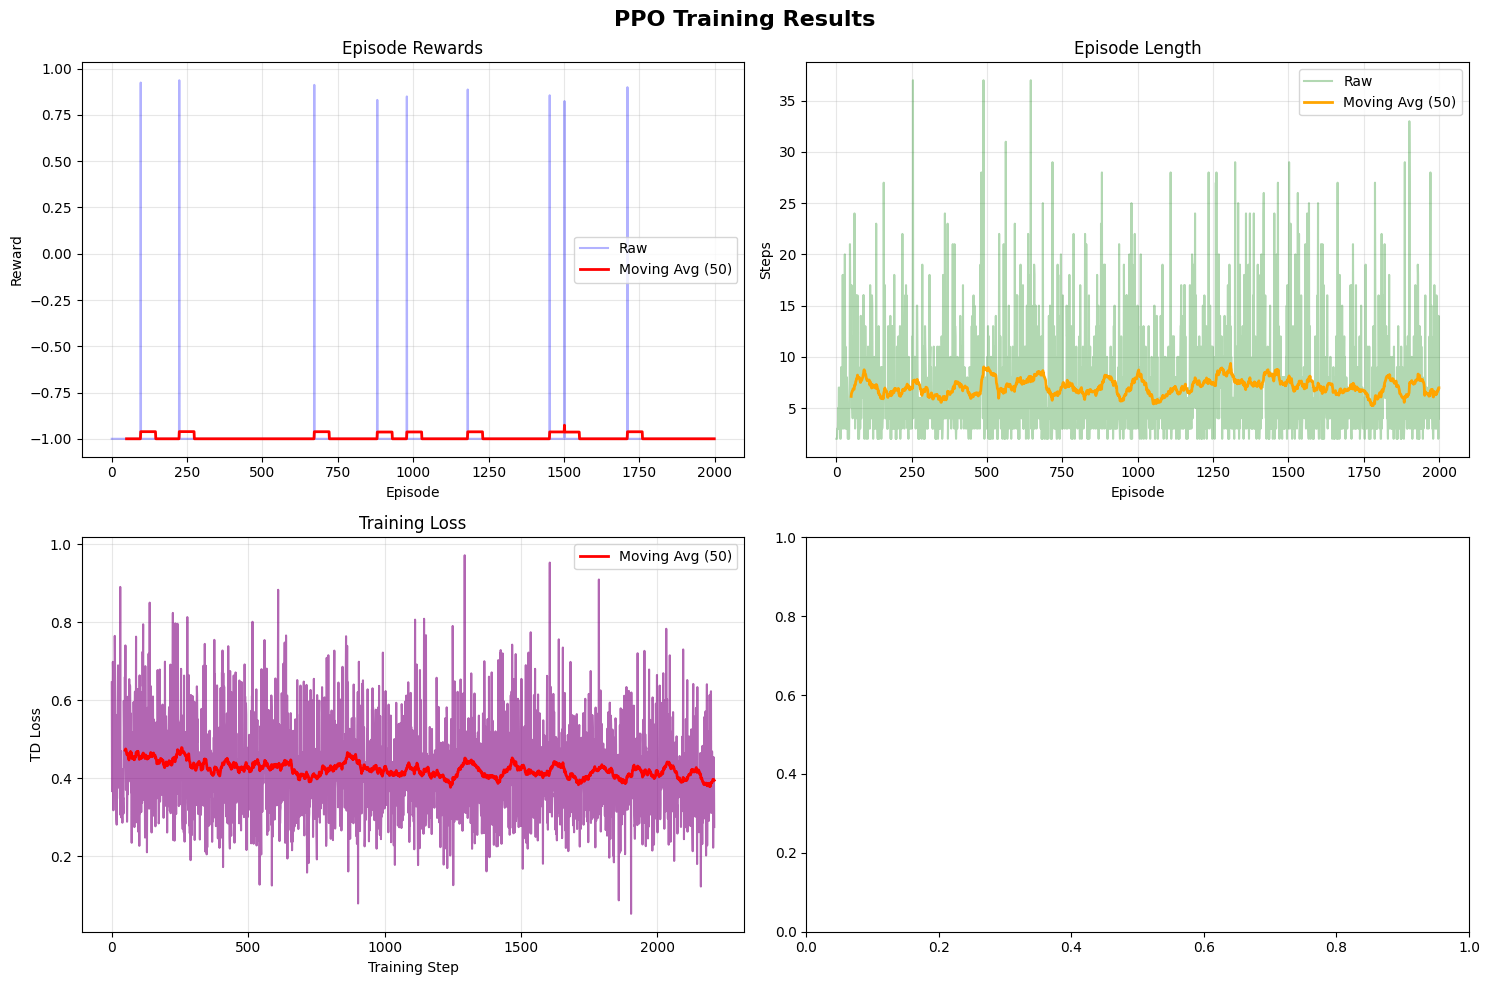

Model exported to: models/6x6/ppo_model.pth


In [180]:
ppo_logs = run_experiment('PPO',
                          env_name="MiniGrid-Dynamic-Obstacles-5x5-v0",
    num_episodes=1000,
)